In [1]:
import numpy as np
import popstock
import bilby

pretty plots preamble

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.fontsize'] = 20

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


# Models

Instantiate the mass and redshift models; here we use "standard" choices.

In [3]:
from gwpopulation.models.mass import SinglePeakSmoothedMassDistribution
from gwpopulation.models.redshift import MadauDickinsonRedshift

mass_obj = SinglePeakSmoothedMassDistribution()
redshift_obj = MadauDickinsonRedshift(z_max=10)

models = {
        'mass_model' : mass_obj,
        'redshift_model' : redshift_obj,
        }

# Population $\Omega_{\rm GW}$ object

Create a `PopulationOmegaGW` object, which manages the computations.

This requires minimal input for initialisation:

* The parameter population models (above)
* A frequency array, used to downsample waveforms consistently

In [4]:
from popstock.PopulationOmegaGW import PopulationOmegaGW

freqs = np.arange(10, 2000, 2.5)
newpop = PopulationOmegaGW(models=models, frequency_array=freqs)

Initializing with the following models: 
mass: <gwpopulation.models.mass.SinglePeakSmoothedMassDistribution object at 0x1434d5190>
redshift: <gwpopulation.models.redshift.MadauDickinsonRedshift object at 0x1434d5730>


# Sampling

An empty `PopulationOmegaGW` requires a set of event samples to get started. These can be fed in (if pre-sampled), or sampled by the object directly using the `draw_and_set_proposal_samples` method.

This requires defining: 

* An initial set of population hyperparameters, $\Lambda_0$ (these must match the formalism used in the `models` above)
* The number of event "proposal" samples to use in the calculation

In [5]:
Lambda_0 =  {'alpha': 2.5, 'beta': 1, 'delta_m': 3, 'lam': 0.04, 'mmax': 100, 'mmin': 4, 'mpp': 33, 'sigpp':5, 'gamma': 2.7, 'kappa': 3, 'z_peak': 1.9, 'rate': 15}
N_proposal_samples = int(1.e5)

newpop.draw_and_set_proposal_samples(Lambda_0, N_proposal_samples=N_proposal_samples)

Using 10000000, got 55075 out of target 100000 samples after iteration 0
Efficiency: 0.0055075, trying 8157058 samples in next iteration
-----------------------------------------------------------
Using 8157058, got 99730 out of target 100000 samples after iteration 1
Efficiency: 0.005474400206545056, trying 10109783 samples in next iteration
-----------------------------------------------------------
Using 10109783, got 155640 out of target 100000 samples after iteration 2
Efficiency: 0.005530286851854288, trying 7972461 samples in next iteration
-----------------------------------------------------------
Drawing redshift samples
{'gamma': 2.7, 'kappa': 3, 'z_peak': 1.9}


# Calculate $\Omega_{\rm GW}$

The `calculate_omega_gw` method does just that; if no $\Lambda$ parameters are passed, the ones used while sampling will be used.
When calculating $\Omega_{\rm GW}$ for the first time, this may take some time as individual waveforms need to be evaluated. 
Activating `multiprocessing` is useful here. 
If $\Omega_{\rm GW}$ has already been calculated once by the `PopulationOmegaGW` object, the stored samples are re-weighted to the desired
$\Lambda$ set.

In [6]:
newpop.calculate_omega_gw(Lambda=Lambda_0, multiprocess=True)

11:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using multiprocessing, no status bar currently supported... 


In [7]:
import matplotlib.pyplot as plt

Text(0, 0.5, '$\\Omega_{\\rm GW}$')

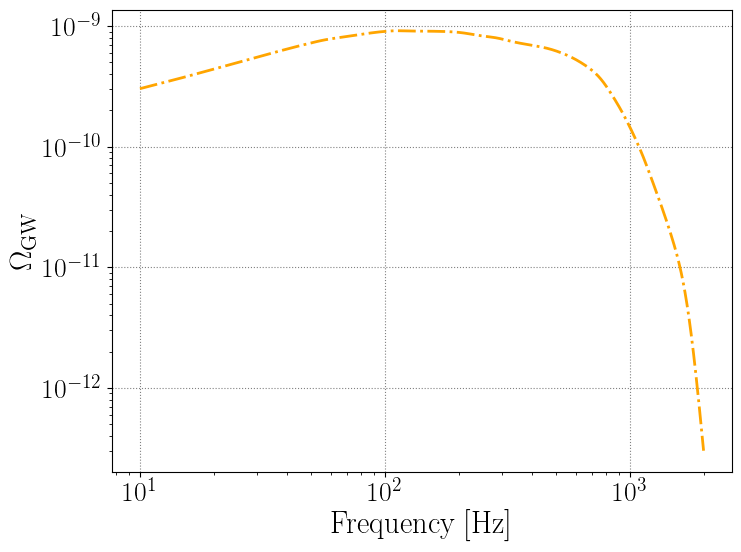

In [8]:
plt.loglog(newpop.frequency_array, newpop.omega_gw, color='orange', linestyle='-.')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}$')

## Example use: recalculating $\Omega_{\rm GW}$ for a different choice of hyperparameters $\Lambda$

In [9]:
# store the old omega for comparison

import copy
omega_0 = copy.copy(newpop.omega_gw)

when re-calling the `calculate_omega_gw` method with a new set of $\Lambda$, the samples are re-weighted to satisfy the new population model configuration.

In [11]:
# create a new set of Lambdas, with a different value of alpha

Lambda_new =  {'alpha': 4.5, 'beta': 1, 'delta_m': 3, 'lam': 0.04, 'mmax': 100, 'mmin': 4, 'mpp': 33, 'sigpp':5, 'gamma': 2.7, 'kappa': 3, 'z_peak': 1.9, 'rate': 15}

newpop.calculate_omega_gw(Lambda=Lambda_new)

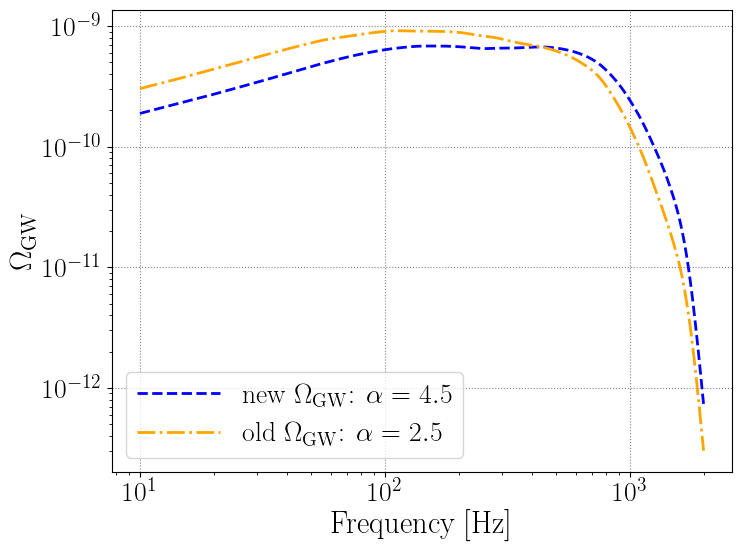

In [14]:
plt.loglog(newpop.frequency_array, newpop.omega_gw, color='blue', linestyle='--', label=r'new $\Omega_{\rm GW}$: $\alpha=4.5$')
plt.loglog(newpop.frequency_array, omega_0, color='orange', linestyle='-.', label=r'old $\Omega_{\rm GW}$: $\alpha=2.5$')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}$')

plt.legend()

### With `popstock`, these calculations are really fast, we can sample over different values of the hyper-parameters efficiently! Below an easy set of examples

* VARYING $\alpha$

In [15]:
# draw alpha from a Gaussian
alphas = np.random.normal(loc=2.5, scale=0.8, size=1000)
omegas_alphas = []

# re-calculate omega for each alpha
for alpha in alphas:
    Lambda_new['alpha'] = alpha
    newpop.calculate_omega_gw(Lambda=Lambda_new)
    omegas_alphas.append(newpop.omega_gw)

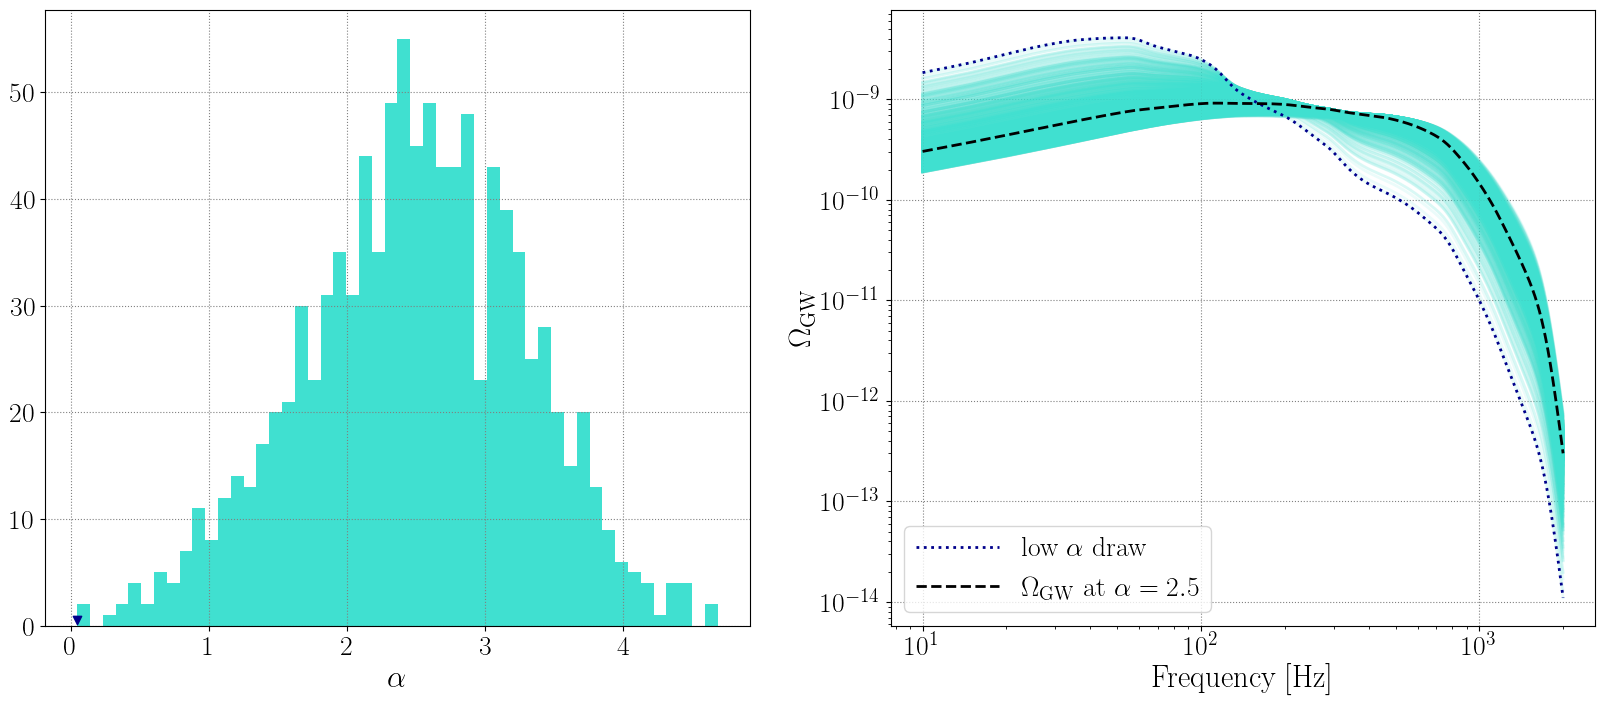

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8) )

ax[0].hist(alphas, bins=50, color='turquoise')
ax[0].scatter(alphas[np.where(alphas<0.2)[0][0]], 0.5, color='darkblue', marker='v')
ax[0].set_xlabel(r'$\alpha$')

for om in omegas_alphas:
    ax[1].loglog(newpop.frequency_array, om, color='turquoise', linestyle='-', alpha=0.1)

ax[1].loglog(newpop.frequency_array, omegas_alphas[np.where(alphas<0.2)[0][0]], color='darkblue', linestyle=':', linewidth=2, label=r'low $\alpha$ draw')

ax[1].loglog(newpop.frequency_array, omega_0, color='k', linestyle='--', label=r'$\Omega_{\rm GW}$ at $\alpha=2.5$')

ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel(r'$\Omega_{\rm GW}$')
ax[1].legend()

* VARYING $\beta$

In [21]:
betas = np.random.normal(loc=1, scale=2.0, size=1000)
omegas_betas = []

# reset alpha to some sensible value
Lambda_new['alpha'] = 2.5

for beta in betas:
    Lambda_new['beta'] = beta
    newpop.calculate_omega_gw(Lambda=Lambda_new)
    omegas_betas.append(newpop.omega_gw)

Text(0, 0.5, '$\\Omega_{\\rm GW}$')

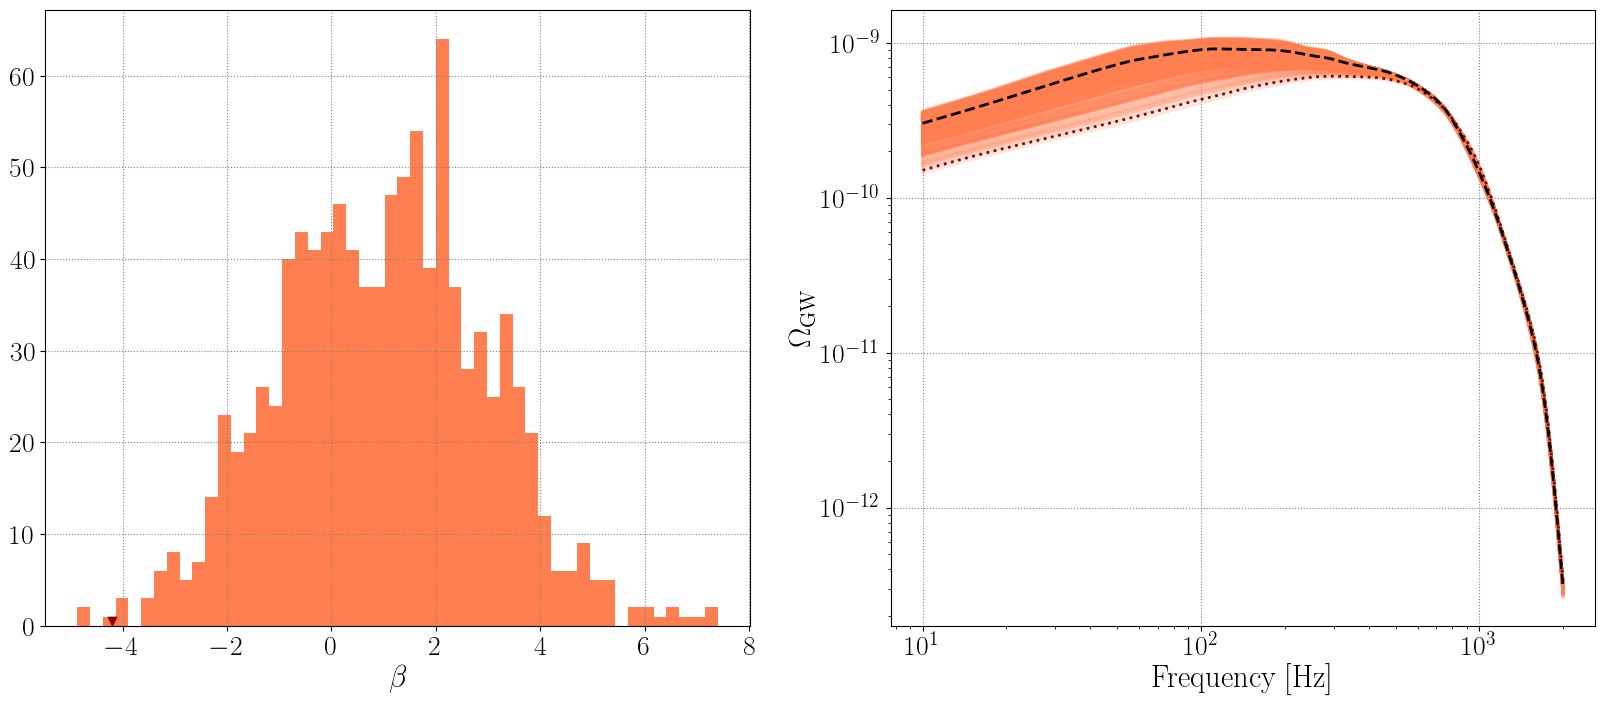

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8) )


ax[0].hist(betas, bins=50, color='coral')
ax[0].scatter(betas[np.where(betas<-4)[0][0]], 0.5, color='darkred', marker='v')
ax[0].set_xlabel(r'$\beta$')

for om in omegas_betas:
    ax[1].loglog(newpop.frequency_array, om, color='coral', linestyle='-', alpha=0.1)

ax[1].loglog(newpop.frequency_array, omegas_betas[np.where(betas<-4)[0][0]], color='darkred', linestyle=':', linewidth=2, label=r'low $\beta$ draw')

ax[1].loglog(newpop.frequency_array, omega_0, color='k', linestyle='--', label=r'$\Omega_{\rm GW}$ at $\beta=1$')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel(r'$\Omega_{\rm GW}$')